In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [4]:
file_path = '/Users/apple/Desktop/PG/Summer-24/Fintech/popcat-usd-max.csv'
# Load and preprocess the data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['snapped_at'] = pd.to_datetime(df['snapped_at'])
    df.set_index('snapped_at', inplace=True)
    df.sort_index(inplace=True)
    
    # Calculate additional volatility features
    df['price_change'] = df['price'].pct_change()
    df['rolling_std'] = df['price'].rolling(window=30).std()
    df['bollinger_upper'] = df['price'] + (df['rolling_std'] * 2)
    df['bollinger_lower'] = df['price'] - (df['rolling_std'] * 2)
    
    # Drop rows with NaN values
    df.dropna(inplace=True)
    
    return df

In [6]:
# Check the column names in the CSV file
print(df.columns)

Index(['price', 'market_cap', 'total_volume', 'price_change', 'rolling_std',
       'bollinger_upper', 'bollinger_lower'],
      dtype='object')


/Users/apple/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 540ms/step - loss: 0.5446 - val_loss: 0.0635
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0529 - val_loss: 0.0672
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0723 - val_loss: 0.0223
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0225 - val_loss: 0.0394
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0353 - val_loss: 0.0443
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0332 - val_loss: 0.0284
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0230 - val_loss: 0.0197
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0232 - val_loss: 0.0190
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0222 - val_loss: 0.0181
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0183 - val_loss: 0.0182
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0163 - val_loss: 0.0197
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0186 - val_l

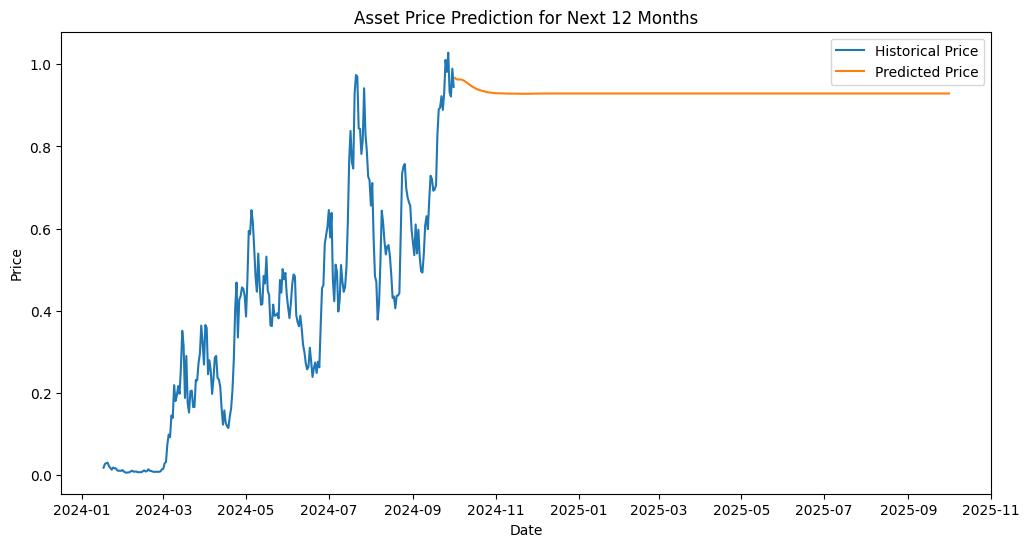

In [5]:


# Create sequences for LSTM input
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :-1])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)

# Build and train LSTM model
def build_and_train_model(X_train, y_train, X_val, y_val):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1,
        shuffle=False
    )
    
    return model, history

def predict_next_12_months(model, last_sequence, scaler, feature_count):
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(365):  # Assuming daily data for a year
        next_pred = model.predict(current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1]))
        predictions.append(next_pred[0, 0])
        
        # Update the sequence for the next prediction
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1, :-1] = current_sequence[-2, :-1]  # Assume other features remain constant
        current_sequence[-1, -1] = next_pred[0, 0]
    
    # Prepare the predictions for inverse transform
    pred_array = np.zeros((len(predictions), feature_count))
    pred_array[:, 0] = predictions  # Assuming price is the first feature
    
    # Inverse transform the predictions to get actual prices
    inverse_transformed = scaler.inverse_transform(pred_array)
    price_predictions = inverse_transformed[:, 0]  # Extract the price column
    
    return price_predictions

# Main execution
if __name__ == "__main__":
    # Load and preprocess the data
    df = load_and_preprocess_data(file_path)
    
    # Select features for the model
    features = ['price', 'market_cap', 'total_volume', 'price_change', 'rolling_std']
    target = 'price'
    
    # Normalize the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[features + [target]])
    
    # Create sequences
    seq_length = 60  # Use 60 days of historical data to predict the next day
    X, y = create_sequences(scaled_data, seq_length)
    
    # Split the data into train, validation, and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    # Build and train the model
    model, history = build_and_train_model(X_train, y_train, X_val, y_val)
    
    # Evaluate the model
    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)
    test_predictions = model.predict(X_test)
    
    # Prepare predictions for inverse transform
    train_pred_array = np.zeros((len(train_predictions), len(features) + 1))
    train_pred_array[:, 0] = train_predictions.flatten()
    val_pred_array = np.zeros((len(val_predictions), len(features) + 1))
    val_pred_array[:, 0] = val_predictions.flatten()
    test_pred_array = np.zeros((len(test_predictions), len(features) + 1))
    test_pred_array[:, 0] = test_predictions.flatten()
    
    # Inverse transform
    train_predictions = scaler.inverse_transform(train_pred_array)[:, 0]
    val_predictions = scaler.inverse_transform(val_pred_array)[:, 0]
    test_predictions = scaler.inverse_transform(test_pred_array)[:, 0]
    
    y_train_actual = scaler.inverse_transform(np.zeros((len(y_train), len(features) + 1)))[:, 0]
    y_val_actual = scaler.inverse_transform(np.zeros((len(y_val), len(features) + 1)))[:, 0]
    y_test_actual = scaler.inverse_transform(np.zeros((len(y_test), len(features) + 1)))[:, 0]
    
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predictions))
    val_rmse = np.sqrt(mean_squared_error(y_val_actual, val_predictions))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
    
    print(f"Train RMSE: {train_rmse}")
    print(f"Validation RMSE: {val_rmse}")
    print(f"Test RMSE: {test_rmse}")
    
    # Predict the next 12 months
    last_sequence = X[-1]
    future_predictions = predict_next_12_months(model, last_sequence, scaler, len(features) + 1)
    
    # Calculate the predicted price range
    last_known_price = df['price'].iloc[-1]
    min_predicted_price = np.min(future_predictions)
    max_predicted_price = np.max(future_predictions)
    
    print(f"Last known price: {last_known_price:.4f}")
    print(f"Predicted price range for the next 12 months:")
    print(f"Min: {min_predicted_price:.4f}")
    print(f"Max: {max_predicted_price:.4f}")
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-365:], df['price'].iloc[-365:], label='Historical Price')
    plt.plot(pd.date_range(start=df.index[-1], periods=366, freq='D')[1:], future_predictions, label='Predicted Price')
    plt.title('Asset Price Prediction for Next 12 Months')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    